# Dense Trajectories (DT features) with Fisher encoding


## A short summary


<font color='red'>This feature extraction process removes the **human detector**, **SURF features**, **RANSAC estimation**.</font>

This jupyter notebook shows the feature analysis on the iCetanaPrivate dataset. To visualize the feature space, we use two experimental settings, which are t-SNE with PCA applied for feature dimensionality reduction and t-SNE only for feature dimensionality reduction. There are 4 csv files created when running this jupyter notebook:

- `DT_features.csv`: a concatenation of a subset of DT features (around 120 videos)
- `sampled_features.csv`: a random sampling of 100,000 DT features extracted from the dataset for a GMM estimation
- `fisher_vectors.csv`: a concatenation of all the fisher encoded DT features for the iCetanaPrivate dataset
- `all_labels.csv`: a list of labels for the whole dataset (total 270 videos)

The fisher kernel implementation is based on the ICCV 2011 paper: *J. Krapac, J. Verbeek, F.Jurie. Modeling Spatial Layout with Fisher Vectors for Image Categorization.*

Most of the parameters we used in our experiments are the default values given by the author, such as trajectory length $L=5$, and spatiotemporal grid size $n_\sigma \times n_\sigma \times n_t = 2 \times 2 \times 3$. Other parameters that we updated in our experiments are shown in the following:

- The number of Gaussians $K$: 128
- The dimension of fisher vector: $K + 2DK$, where $D$ is the descriptor dimension
- Sampled feature vectors for building a GMM estimation: 100,000


## 1 Data preprocessing
In this step, we concatenate all the DT features extracted from the iCetanaPrivateDataset. Moreover, we also get the labels for the videos and concatenate them together for further analysis (e.g., plot data points in t-SNE space with different colors specified by labels).

In [4]:
import glob
import gzip
import pandas as pd
import numpy as np

# define an empty numpy array for concatenating features
all_features=np.array([])

a=0
# concatenate all the extracted features and video labels
for filename in glob.iglob('DT_features/*.gz'):
    # print(filename)
    # use '\s+' for the \t and \n
    df = pd.read_table(gzip.open(filename),sep='\s+', header=None)
    
    # turn pandas dataframe into array
    df_array=np.round(df.values, decimals=3)
    print("Concatenating features from: ", filename)
    
    a=a+1
    if a == 120:
        break
        
    # concatenate all the features
    all_features=np.vstack([all_features, df_array]) if all_features.size else df_array
    # print(all_features.shape)
    # print(all_label.shape)
    
    
print("Saving all features into a csv file...")    
df = pd.DataFrame(all_features)
df.to_csv("DT_features.csv", index=False)
print("Done!")

Concatenating features from:  DT_features/0040005.features.gz
Concatenating features from:  DT_features/0011035.features.gz
Concatenating features from:  DT_features/0041042.features.gz
Concatenating features from:  DT_features/0001023.features.gz
Concatenating features from:  DT_features/0050013.features.gz
Concatenating features from:  DT_features/0001053.features.gz
Concatenating features from:  DT_features/0010002.features.gz
Concatenating features from:  DT_features/0040047.features.gz
Concatenating features from:  DT_features/0000056.features.gz
Concatenating features from:  DT_features/0040037.features.gz
Concatenating features from:  DT_features/0011007.features.gz
Concatenating features from:  DT_features/0001061.features.gz
Concatenating features from:  DT_features/0000008.features.gz
Concatenating features from:  DT_features/0011029.features.gz
Concatenating features from:  DT_features/0001011.features.gz
Concatenating features from:  DT_features/0051048.features.gz
Concaten

## 2 Gaussian Mixture Model (GMM)
We use the concatenated features (random sampling 100,000 feature vectors) to get an estimation of a Gaussian Mixture Model for the whole dataset (here we use the iCetanaPrivateDataset as an example). At this stage, we set the number of Gaussians $K=128$, which is different from the original authors' in the DT paper. Moreover, at this stage, we do not apply the principle component analysis (PCA) on the concatenated features for feature dimensionality reduction.

### 2.1 Random sampling

In [ ]:
import pandas as pd
descriptors = pd.read_csv('DT_features.csv')
descriptors=descriptors.iloc[:, 10:]
print("Read csv file successfully!")
# random sample 100,000 feature vectors
print("Start sampling 100,000 feature vectors")
f_samp=descriptors.sample(n=100000, random_state=42)
print("Save sampled feature vectors...")
f_samp.to_csv("sampled_features.csv", index=False)
print("Done!")
print(f_samp.shape)

### 2.2 GMM estimation

In [2]:
import pandas as pd
# import sklearn GMM model
from sklearn.mixture import GMM
# ignore all warning messages
import warnings
warnings.filterwarnings("ignore")

# define K
K = 128
gmm = GMM(n_components=K, covariance_type='diag')

# get a GMM estimation for the whole dataset
samp_f = pd.read_csv('sampled_features.csv')
print("Read csv file successfully!")
print("Start the GMM estimation...")
gmm.fit(samp_f)
print("A GMM estimation for the whole dataset has been finished!")

Read csv file successfully!
Start the GMM estimation...
A GMM estimation for the whole dataset has been finished!


## 3 Feature encoding using fisher kernel

Now, we use the fisher kernel to encoding the features. For more details about our fisher encoding algorithm, please refer to our code (`fisher_vector.py`)

In [3]:
# import fisher encoding function
import numpy as np
import glob
import gzip
import pandas as pd
from fisher_vector import fisher_vector

# define an empty numpy array to store all the fisher encoding
fisher_vec=np.array([])
all_label=np.array([])
# loop through each video to get the fisher encoding
for filename in sorted(glob.iglob('DT_features/*.gz')):
    # use '\s+' for the \t and \n
    df = pd.read_table(gzip.open(filename),sep='\s+', header=None)
    df = df.iloc[:, 10:]
    # concatenate all the labels
    vlabel=np.asarray(int(filename[15:16]))
    all_label=np.vstack([all_label, vlabel]) if all_label.size else vlabel
    
    # turn pandas dataframe into array
    df_array=np.round(df.values, decimals=3)
    
    # get the fisher vector for each video sequence
    print('Start fisher encoding for %s' % filename)
    fv = np.round(fisher_vector(df_array, gmm), decimals=6)
    
    fisher_vec=np.vstack([fisher_vec, fv]) if fisher_vec.size else fv
# save the fisher encoded features for the whole dataset
print("Saving the fisher encoded features into a csv file...")
print(fisher_vec.shape)
fv_storage= pd.DataFrame(fisher_vec)
fv_storage.to_csv("fisher_vectors.csv", index=False)
print("Done!")
print("Saving all the labels into a csv file...")
df_label= pd.DataFrame(all_label)
df_label.to_csv("all_labels.csv", index=False)
print("Done!")

Start fisher encoding for DT_features/0000003.features.gz
Start fisher encoding for DT_features/0000004.features.gz
Start fisher encoding for DT_features/0000006.features.gz
Start fisher encoding for DT_features/0000007.features.gz
Start fisher encoding for DT_features/0000008.features.gz
Start fisher encoding for DT_features/0000009.features.gz
Start fisher encoding for DT_features/0000010.features.gz
Start fisher encoding for DT_features/0000013.features.gz
Start fisher encoding for DT_features/0000017.features.gz
Start fisher encoding for DT_features/0000020.features.gz
Start fisher encoding for DT_features/0000024.features.gz
Start fisher encoding for DT_features/0000027.features.gz
Start fisher encoding for DT_features/0000028.features.gz
Start fisher encoding for DT_features/0000029.features.gz
Start fisher encoding for DT_features/0000030.features.gz
Start fisher encoding for DT_features/0000031.features.gz
Start fisher encoding for DT_features/0000033.features.gz
Start fisher e

Start fisher encoding for DT_features/0040001.features.gz
Start fisher encoding for DT_features/0040002.features.gz
Start fisher encoding for DT_features/0040003.features.gz
Start fisher encoding for DT_features/0040004.features.gz
Start fisher encoding for DT_features/0040005.features.gz
Start fisher encoding for DT_features/0040006.features.gz
Start fisher encoding for DT_features/0040008.features.gz
Start fisher encoding for DT_features/0040009.features.gz
Start fisher encoding for DT_features/0040010.features.gz
Start fisher encoding for DT_features/0040011.features.gz
Start fisher encoding for DT_features/0040012.features.gz
Start fisher encoding for DT_features/0040013.features.gz
Start fisher encoding for DT_features/0040014.features.gz
Start fisher encoding for DT_features/0040015.features.gz
Start fisher encoding for DT_features/0040016.features.gz
Start fisher encoding for DT_features/0040017.features.gz
Start fisher encoding for DT_features/0040019.features.gz
Start fisher e

### 3.1 A glance of fisher encoded DT feature

In [15]:
import pandas as pd
fv_info = pd.read_csv('fisher_vectors.csv')
fv_info.head()

,0,1,2,3,4,5,6,7,8,9,...,109174,109175,109176,109177,109178,109179,109180,109181,109182,109183
0,-0.005660,-0.011786,-0.014118,-0.006284,-0.003553,-0.005048,-0.005099,-0.006175,-0.004669,-0.013202,...,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000
1,-0.005618,-0.011514,-0.014186,-0.006267,-0.003553,-0.003380,-0.005049,-0.006169,-0.004669,-0.013199,...,0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000
2,-0.005381,0.027035,-0.008809,-0.004444,-0.003553,-0.004703,-0.002357,0.034120,-0.004669,-0.011317,...,-0.000033,-0.000045,0.000073,0.000007,0.000005,0.000017,0.000100,0.000085,-0.000007,0.000024
3,-0.005660,-0.006885,-0.013874,-0.005545,-0.003553,-0.005309,-0.005071,-0.004592,-0.004641,-0.003102,...,0.000117,0.000162,0.000260,0.000236,0.000272,0.000201,0.000194,0.000229,0.000218,0.000239
4,-0.005660,0.082065,-0.014144,-0.003994,-0.003530,-0.005299,-0.004885,-0.001799,-0.004669,-0.012595,...,0.000282,0.000167,0.000062,0.000103,0.000147,0.000128,0.000111,0.000106,0.000140,0.000109


## 4 Feature space visualization
We use t-SNE to visualize the feature space for the iDT features extracted from the iCetanaPrivate dataset. We use the labels of the videos to color each fisher encoded representation in this feature space for further analysis.

First, defining the mapping between labels and colors, as well as the relationship between labels and dynamic environment issues.

In [16]:
def colormap(c):
    if c==0:
        color='r'
    elif c==1:
        color='g'
    elif c==2:
        color='b'
    elif c==3:
        color='c'
    elif c==4:
        color='m'
    elif c==5:
        color='k'
    return color

def labelmap(c):
    if c==0:
        label='normal video'
    elif c==1:
        label='illumination'
    elif c==2:
        label='noise video'
    elif c==3:
        label='rain'
    elif c==4:
        label='camera shake'
    elif c==5:
        label='tree wave'
    return label

In [17]:
# power and L2 normalization for fisher vector
def power_normalize(xx, alpha=0.5):
    """Computes a alpha-power normalization for the matrix xx."""
    return np.sign(xx) * np.abs(xx) ** alpha
 
def L2_normalize(xx):
    """L2-normalizes each row of the data xx."""
    Zx = np.sum(xx * xx, 1)
    xx_norm = np.divide(xx, np.sqrt(Zx[:, np.newaxis]))
    xx_norm[np.isnan(xx_norm)] = 0
    return xx_norm

In [18]:
import numpy as np
fv_info=power_normalize(fv_info, alpha=0.5)
fv_info=L2_normalize(fv_info)

### 4.1 t-SNE with PCA applied

#### 4.1.1 PCA for feature dimensionality reduction
In this part, we keep the feature importance for up to 98% when using the PCA.

In [19]:
from sklearn.decomposition import PCA
import time
from sklearn.manifold import TSNE

time_start = time.time()

pca = PCA(n_components=0.98)
pca_result = pca.fit_transform(fv_info.values)

pca_features=pca_result

print(pca_features.shape)

print("Saving the features after applying PCA into a csv file...")
pca= pd.DataFrame(pca_features)
pca.to_csv("iCetana_FV_PCA_features_DT.csv", index=False)
print("Done!")

(270, 226)
Saving the features after applying PCA into a csv file...
Done!


In [20]:
pca_tsne = TSNE(n_components=2, verbose=1, perplexity=15, n_iter=10000)
pca_tsne_results = pca_tsne.fit_transform(pca_features)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 46 nearest neighbors...
[t-SNE] Indexed 270 samples in 0.001s...
[t-SNE] Computed neighbors for 270 samples in 0.028s...
[t-SNE] Computed conditional probabilities for sample 270 / 270
[t-SNE] Mean sigma: 0.401712
[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.762047
[t-SNE] Error after 2250 iterations: 0.566349
t-SNE done! Time elapsed: 8.701471090316772 seconds


In [21]:
df_label = pd.read_csv('all_labels.csv')

#### 4.1.2 t-SNE space visualization

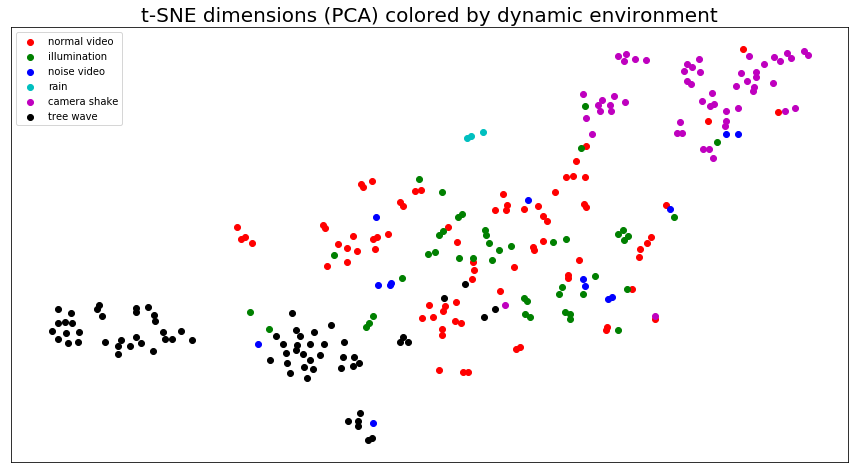

In [22]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np

plt.rcParams["figure.figsize"] = (15,8)
x_tsne=pca_tsne_results[:, 0]
y_tsne=pca_tsne_results[:, 1]

labels=df_label.values
#print(labels)

x=np.c_[x_tsne]
y=np.c_[y_tsne]

plt.xticks([])
plt.yticks([])
plt.title('t-SNE dimensions (PCA) colored by dynamic environment', fontsize=20)

seen=set()
for i, j, c in zip(x, y, labels):
    c=int(c)
    plt.scatter(i, j, c=colormap(c), marker="o", cmap='jet', label=labelmap(c) if c not in seen else None)
    seen.add(c)
    #plt.annotate(c, (i,j))
plt.legend()    
plt.show()

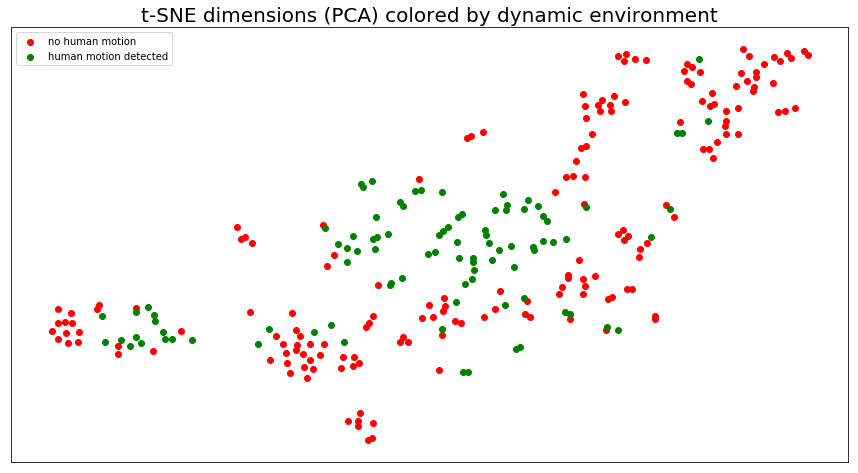

In [23]:
def colormap_h(c):
    if c==0:
        color='r'
    else:
        color='g'

    return color

def labelmap_h(c):
    if c==0:
        label='no human motion'
    else:
        label='human motion detected'
    return label

df_label = pd.read_csv('human_labels.csv')
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np

plt.rcParams["figure.figsize"] = (15,8)
x_tsne=pca_tsne_results[:, 0]
y_tsne=pca_tsne_results[:, 1]

labels=df_label.values
#print(labels)

x=np.c_[x_tsne]
y=np.c_[y_tsne]

plt.xticks([])
plt.yticks([])
plt.title('t-SNE dimensions (PCA) colored by dynamic environment', fontsize=20)

seen=set()
for i, j, c in zip(x, y, labels):
    c=int(c)
    plt.scatter(i, j, c=colormap_h(c), marker="o", cmap='jet', label=labelmap_h(c) if c not in seen else None)
    seen.add(c)
    #plt.annotate(c, (i,j))
plt.legend()    
plt.show()

In [24]:
def colormap_all(c):
    if c==0:
        color='silver'
        # color='w'
    elif c==1:
        color='black'
        # color='w'
    elif c==10:
        color='fuchsia'
    elif c==11:
        color='red'
    elif c==20:
        color='paleturquoise'
        # color='w'
    elif c==21:
        color='darkcyan'
        # color='w'
    elif c==30:
        color='hotpink'
    elif c==31:
        color='pink'
    elif c==40:
        color='cornflowerblue'
    elif c==41:
        color='b'
    elif c==50:
        color='greenyellow'
    elif c==51:
        color='limegreen'
    return color

def labelmap_all(c):
    if c==0:
        label='normal video_N'
    elif c==1:
        label='normal video_Y'
    elif c==10:
        label='illumination_N'
    elif c==11:
        label='illumination_Y'
    elif c==20:
        label='noise video_N'
    elif c==21:
        label='noise video_Y'
    elif c==30:
        label='rain_N'
    elif c==31:
        label='rain_Y'
    elif c==40:
        label='camera shake_N'
    elif c==41:
        label='camera shake_Y'
    elif c==50:
        label='tree wave_N'
    elif c==51:
        label='tree wave_Y'
    return label

In [25]:
df_h_e_label = pd.read_csv('human_env_labels.csv')

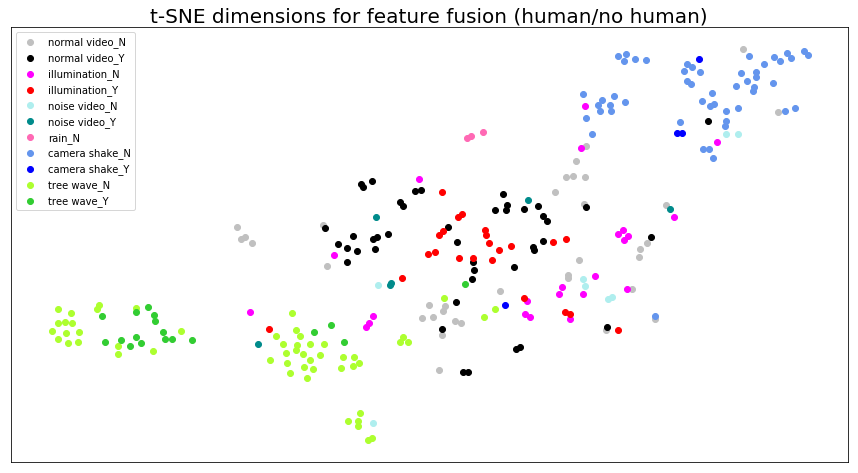

In [26]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np

plt.rcParams["figure.figsize"] = (15,8)
x_tsne=pca_tsne_results[:, 0]
y_tsne=pca_tsne_results[:, 1]

labels=df_h_e_label.values
#print(labels)

x=np.c_[x_tsne]
y=np.c_[y_tsne]

plt.xticks([])
plt.yticks([])
plt.title('t-SNE dimensions for feature fusion (human/no human)', fontsize=20)

seen=set()
for i, j, c in zip(x, y, labels):
    c=int(c)
    plt.scatter(i, j, c=colormap_all(c), marker="o", cmap='jet', label=labelmap_all(c) if c not in seen else None)
    seen.add(c)
    # plt.annotate(h, (i,j))
plt.legend()    
plt.show()

## The end

In [27]:
df_h_e_label = pd.read_csv('human_env_labels.csv')
all_filename=pd.read_csv('all_filename.csv')

<IPython.core.display.Javascript object>


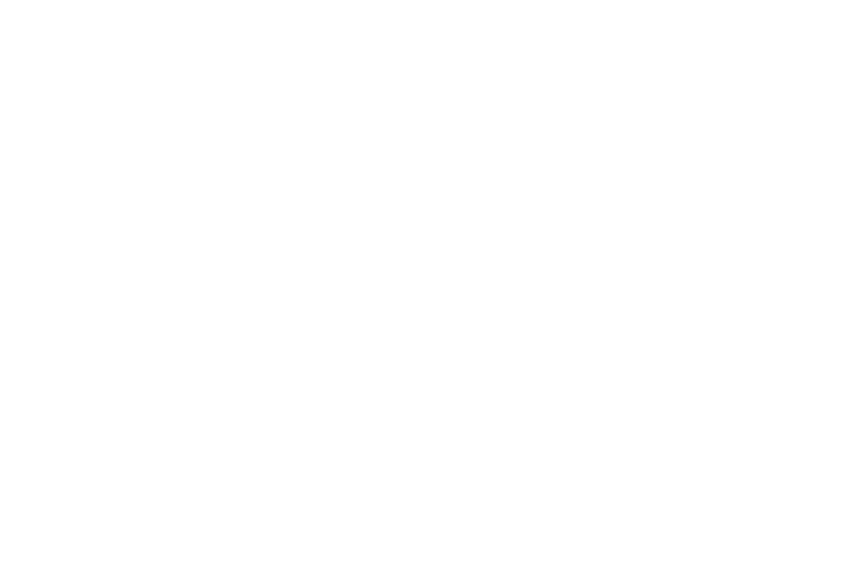

<IPython.core.display.Javascript object>


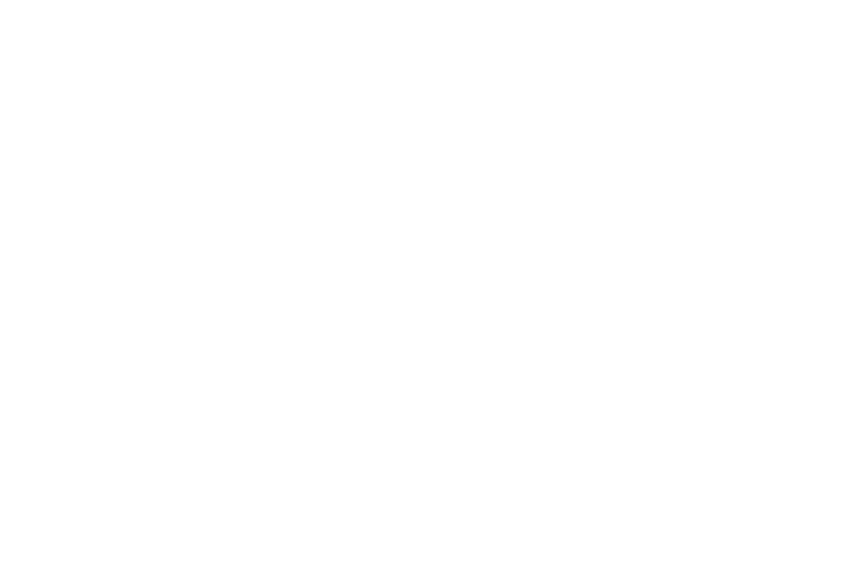

In [28]:
%matplotlib notebook
%matplotlib notebook
from matplotlib import pyplot as plt
import numpy as np

plt.rcParams["figure.figsize"] = (12, 8)
x_tsne=pca_tsne_results[:, 0]
y_tsne=pca_tsne_results[:, 1]

labels=df_h_e_label.values
files=all_filename.values
#print(labels)

x=np.c_[x_tsne]
y=np.c_[y_tsne]

# plt.xticks([])
# plt.yticks([])
# plt.title('t-SNE dimensions for feature fusion (human/no human)', fontsize=20)

fig,ax = plt.subplots()

# seen=set()
# for i, j, c in zip(x, y, labels):
#     c=int(c)
#     sc=plt.scatter(i, j, c=colormap_all(c), marker="o", cmap='jet', label=labelmap_all(c) if c not in seen else None)
#     seen.add(c)
#     # plt.annotate(h, (i,j))

sc=plt.scatter(x, y, c=labels, marker="o", cmap='jet')
    
annot = ax.annotate("", xy=(0,0), xytext=(20,20),textcoords="offset points",
                    bbox=dict(boxstyle="round", fc="w"),
                    arrowprops=dict(arrowstyle="->"))
annot.set_visible(False)

def update_annot(ind):

    pos = sc.get_offsets()[ind["ind"][0]]
    annot.xy = pos
    text=int(files[ind["ind"]])
#     text = "{}, {}".format(" ".join(list(map(str,ind["ind"]))), 
#                            " ".join([names[n] for n in ind["ind"]]))
    annot.set_text(text)
    #annot.get_bbox_patch().set_facecolor(cmap(norm(c[ind["ind"][0]])))
    # annot.get_bbox_patch().set_alpha(0.4)


def hover(event):
    vis = annot.get_visible()
    if event.inaxes == ax:
        cont, ind = sc.contains(event)
        if cont:
            update_annot(ind)
            annot.set_visible(True)
            fig.canvas.draw_idle()
        else:
            if vis:
                annot.set_visible(False)
                fig.canvas.draw_idle()

fig.canvas.mpl_connect("motion_notify_event", hover)

# plt.legend() 
plt.xticks([])
plt.yticks([])
plt.show()